# Tomato Disease Classification

Import all the dependencies

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

Set all the constants

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3

Import data into tensorflow dataset object

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '../../tomato_data' ,
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE 
)

Found 8031 files belonging to 5 classes.


In [4]:
class_names = dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato__Target_Spot',
 'Tomato_healthy']

In [5]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[2 3 3 1 2 0 0 4 3 3 0 0 2 3 0 1 2 2 2 0 3 2 3 0 3 1 2 4 0 3 0 4]


Each element in the dataset is a tuple. First element is a batch of 32 elements of images. Second element is a batch of 32 elements of class labels

**Visualize some of the images from our dataset

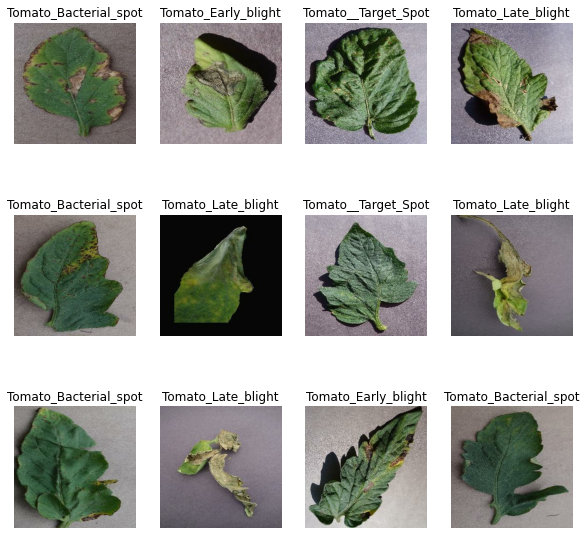

In [6]:
plt.figure(figsize = (10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")
        

Split dataset

In [7]:
len(dataset)

251

In [8]:
train_size = 0.8
len(dataset)*train_size

200.8

In [9]:
train_ds = dataset.take(200)
len(train_ds)

200

In [10]:
test_ds = dataset.skip(200)
len(test_ds)

51

In [11]:
val_size = 0.1
len(dataset)*val_size

25.1

In [12]:
val_ds = test_ds.take(25)
test_ds = test_ds.skip(25)

In [13]:
len(val_ds)

25

In [14]:
len(test_ds)

26

In [15]:
def get_dataset_partition_df(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 1000):
    
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [16]:
train_ds, val_da, test_ds = get_dataset_partition_df(dataset)

In [17]:
len(train_ds)

200

In [18]:
len(val_ds)

25

In [19]:
len(test_ds)

26

Cache, shuffle and prefetch the dataset

In [20]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

# Building the model

Creating a layer for resizing and normalization


Before feed images to network, should be resizing it to the desired size. Moreover, to improve model performance, should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence can add that as a layer in Sequential Model.

In [21]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

Data Augmentation

Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data

In [22]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [23]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training = True), y)
).prefetch(buffer_size = tf.data.AUTOTUNE)

Model Architecture

Use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

In [24]:
input_shape = (BATCH_SIZE, IMAGE_SIZE,IMAGE_SIZE, CHANNELS)
n_classes = 5

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation = "softmax")
])

model.build(input_shape = input_shape)

In [25]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

Compiling the model

Use adam optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [26]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [27]:
history = model.fit(
    train_ds,
    epochs = 10,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/10
200/200 [==============================] - 493s 2s/step - loss: 1.4727 - accuracy: 0.3494 - val_loss: 1.4378 - val_accuracy: 0.2937
Epoch 2/10
200/200 [==============================] - 491s 2s/step - loss: 1.0530 - accuracy: 0.5579 - val_loss: 1.0816 - val_accuracy: 0.5650
Epoch 3/10
200/200 [==============================] - 470s 2s/step - loss: 0.6977 - accuracy: 0.7286 - val_loss: 1.5146 - val_accuracy: 0.5387
Epoch 4/10
200/200 [==============================] - 484s 2s/step - loss: 0.5423 - accuracy: 0.7973 - val_loss: 1.0129 - val_accuracy: 0.6525
Epoch 5/10
200/200 [==============================] - 472s 2s/step - loss: 0.4421 - accuracy: 0.8331 - val_loss: 1.6359 - val_accuracy: 0.5900
Epoch 6/10
200/200 [==============================] - 504s 3s/step - loss: 0.3819 - accuracy: 0.8623 - val_loss: 1.9270 - val_accuracy: 0.5612
Epoch 7/10
200/200 [==============================] - 484s 2s/step - loss: 0.3053 - accuracy: 0.8890 - val_loss: 1.8439 - val_accuracy: 0.6300

In [28]:
score = model.evaluate(test_ds)

26/26 [==============================] - 49s 493ms/step - loss: 2.5835 - accuracy: 0.5349


In [29]:
score

[2.5834972858428955, 0.5348557829856873]

Plotting the Accuracy and Loss curves

In [30]:
history

In [31]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 200}

In [32]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [33]:
history.history['accuracy']

[0.3494296073913574,
 0.5578996539115906,
 0.7285513281822205,
 0.7973120808601379,
 0.8330989480018616,
 0.862322211265564,
 0.8890451788902283,
 0.8965463638305664,
 0.9015471339225769,
 0.9049851298332214]

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and VAlidation loss')

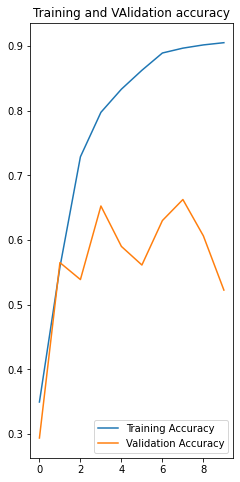

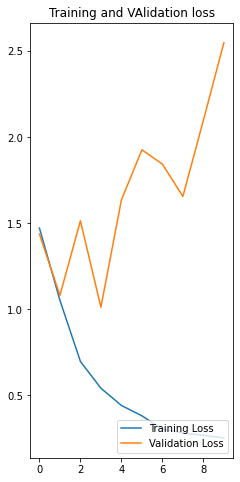

In [37]:
plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.plot(range(10), acc, label = "Training Accuracy")
plt.plot(range(10), val_acc, label = "Validation Accuracy")
plt.legend(loc = "lower right")
plt.title("Training and VAlidation accuracy")

plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.plot(range(10), loss, label = "Training Loss")
plt.plot(range(10), val_loss, label = "Validation Loss")
plt.legend(loc = "lower right")
plt.title("Training and VAlidation loss")

Run prediction on a sample image

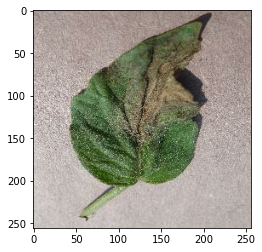

In [39]:
for images_batch, labels_batch in test_ds.take(1):
    
    plt.imshow(images_batch[0].numpy().astype('uint8'))

first image to predict
first image's actual label:  Tomato_Early_blight
1/1 [==============================] - 1s 554ms/step
predicted label :  Tomato_Early_blight


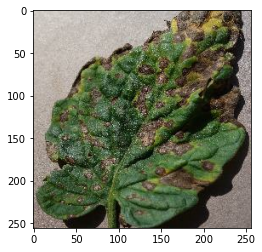

In [40]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    print("first image to predict")
    plt.imshow(first_image)
    print("first image's actual label: ", class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label : ",class_names[np.argmax(batch_prediction[0])])

Function for inference

In [41]:
def predict(model, imges):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) #Create a batch
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 31ms/step


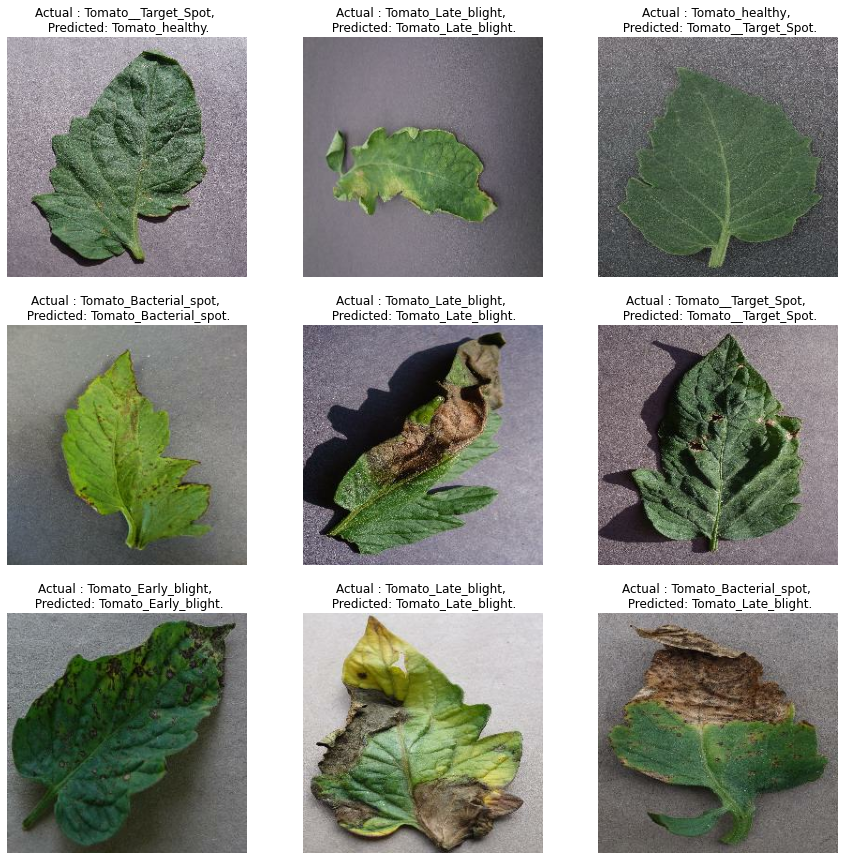

In [42]:
plt.figure(figsize = (15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual : {actual_class}, \n Predicted: {predicted_class}.")
        plt.axis("off")

In [43]:
model_version = 1
model.save(f'../models/{model_version}')

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets
